<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_3/Aula_5_Outliers_e_validacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o conteúdo anterior

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [2]:
## df_esp = estado de são paulo
## df_sp = cidade de são paulo

df_esp = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/dados_covid_sp.zip?raw=true", compression = "zip", sep = ";")

df_esp.loc[:,"datahora"] = pd.to_datetime(df_esp.loc[:,"datahora"], format = "%Y-%m-%d")

df_sp = df_esp.query("nome_munic == 'São Paulo'")
df_sp.loc[:,"ano"] = pd.DatetimeIndex(df_sp.loc[:,"datahora"]).year

mpl.rcParams["font.size"] = 18

df2 = pd.DataFrame()
df2.loc[:,"ds"] = df_sp.loc[:,"datahora"][:400]
df2.loc[:,"y"] = df_sp.loc[:,"casos_novos"][:400]

#Usando feriados especificos do municipio de SP (disponível no notebook da aula)

feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]


feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


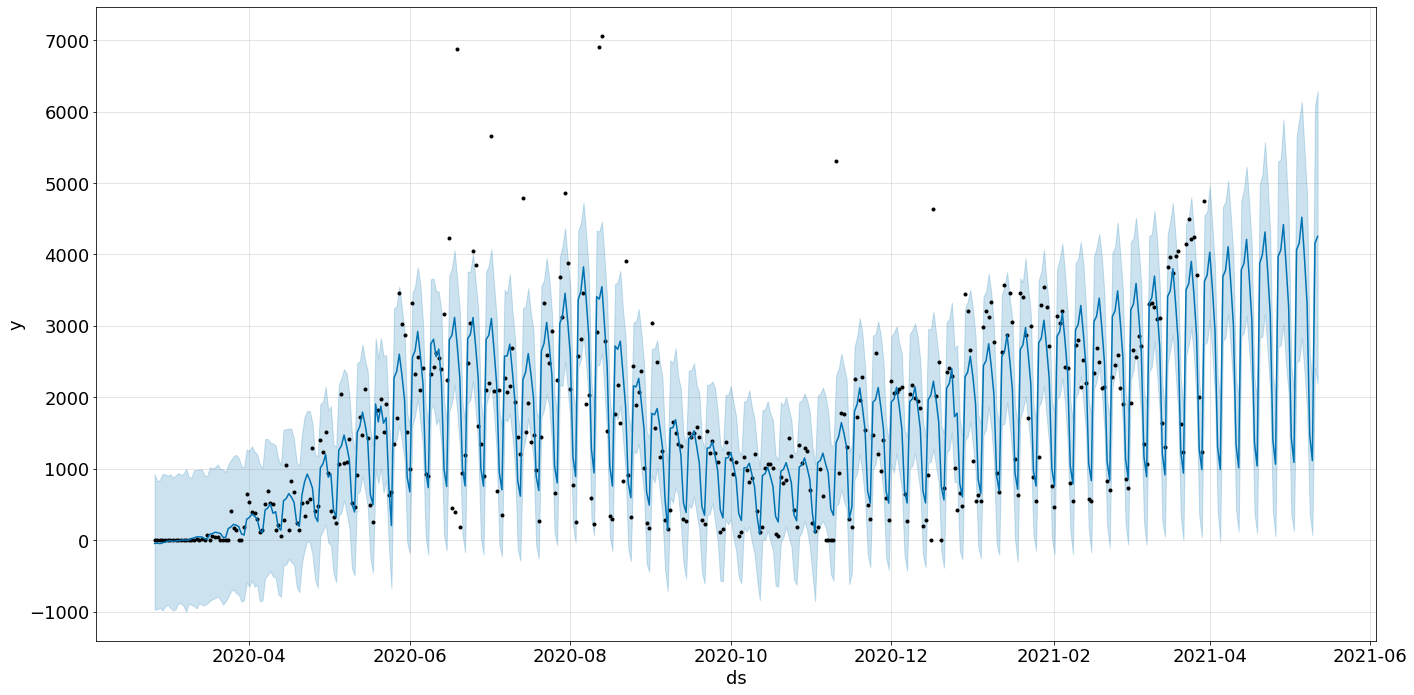

In [3]:
m1 = Prophet(changepoint_prior_scale = 10, holidays = feriados, seasonality_mode = "multiplicative")

m1.fit(df2)
df_prev = m1.make_future_dataframe(periods = 43)

prev = m1.predict(df_prev)

m1.plot(prev, figsize = (20,10));

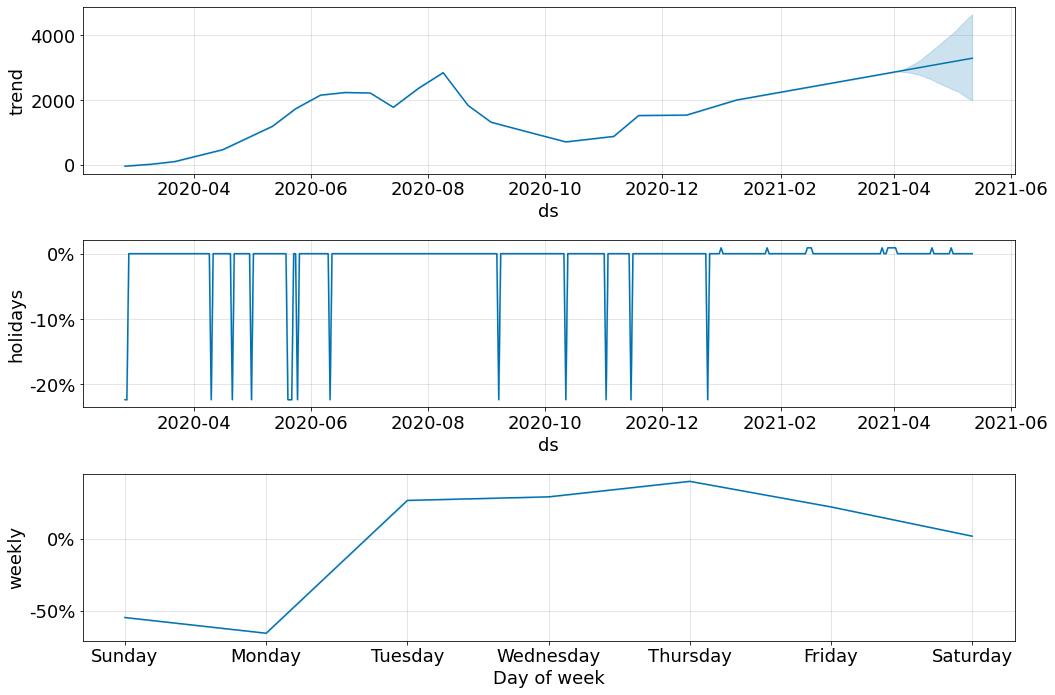

In [4]:
m1.plot_components(prev, figsize = (15,10));

# Sessão 1 - Outliers e intervalo de confiança

#### Exemplo: remover valores fora do intervalo de confiança

In [5]:
novo_y = df2.reset_index()
novo_y

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0
...,...,...,...
395,255337,2021-03-26,4241
396,255982,2021-03-27,3709
397,256627,2021-03-28,2010
398,257272,2021-03-29,1242


In [6]:
no_out = novo_y[(novo_y.loc[:,"y"] > prev.loc[:,"yhat_lower"][:400]) & (novo_y.loc[:,"y"] < prev.loc[:,"yhat_upper"][:400])]

In [7]:
no_out.head()

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0


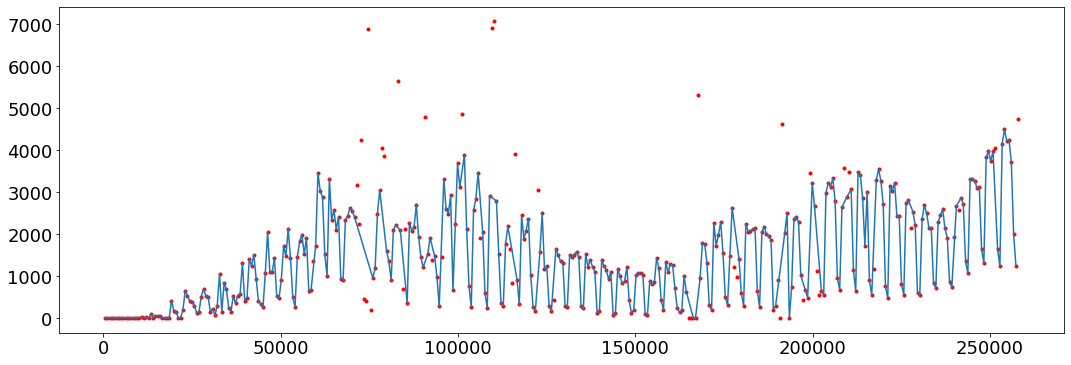

In [8]:
plt.figure(figsize = (18,6))
plt.plot(df2.index, df2.loc[:,"y"], "r.")
plt.plot(no_out.loc[:,"index"], no_out.loc[:,"y"])

In [9]:
df_no_out = no_out.loc[:,["ds", "y"]]
df_no_out.tail()

,ds,y
394,2021-03-25,4214
395,2021-03-26,4241
396,2021-03-27,3709
397,2021-03-28,2010
398,2021-03-29,1242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


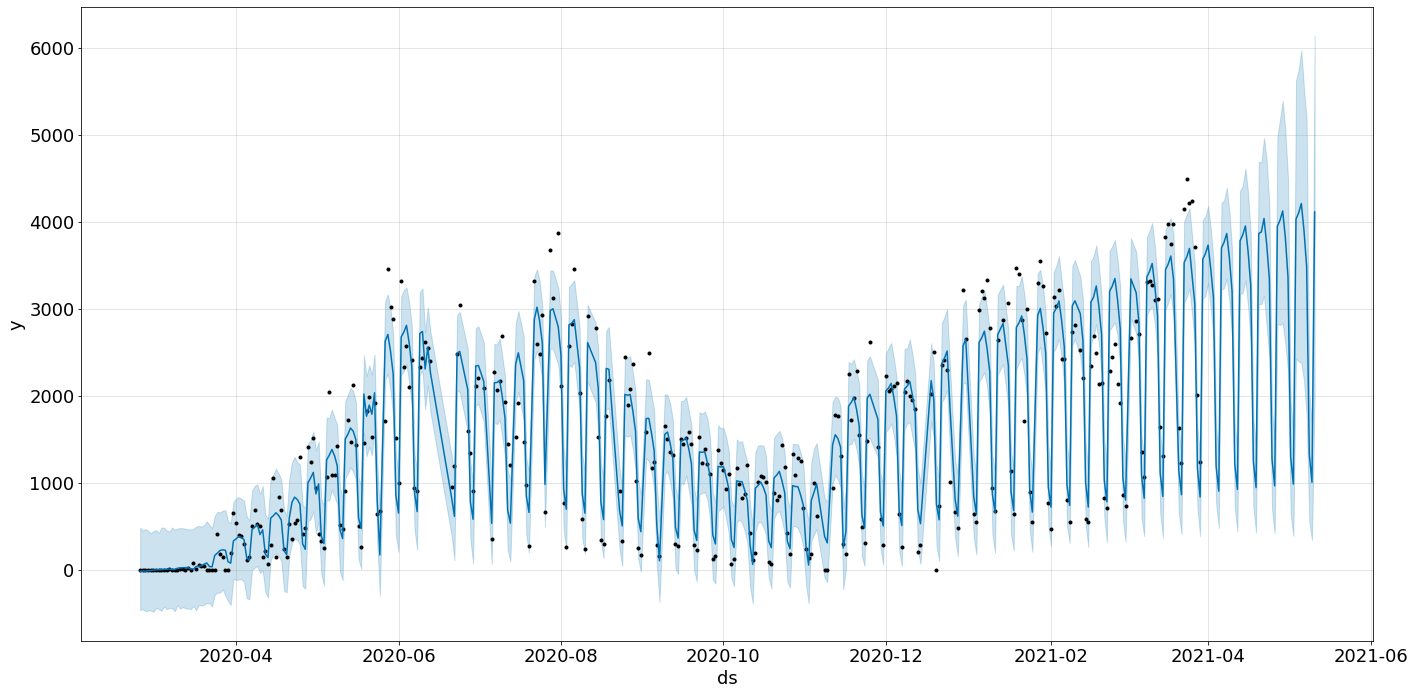

In [10]:
m2 = Prophet(changepoint_prior_scale = 10, holidays = feriados, seasonality_mode = "multiplicative")

m2.fit(df_no_out)

df_prev2 = m2.make_future_dataframe(periods = 43)

prev2 = m2.predict(df_prev2)

m2.plot(prev2, figsize = (20,10));

Durante a aula, houve uma discussão sobre a importância de tratar outliers e os cuidados de se escolher quais remover, ou se remover. Nesse caso da aula, eu escolheria não remover nenhum dado da nossa base de dados, com as informações que temos no momento. Como o Allan mencionou, podem haver casos de falhas no sistema de notificação que alocaram para o dia seguinte, somando um número muito grande de casos neste dia. É uma possibilidade, mas teria que ser investigada com maior conhecimento dos nossos dados.

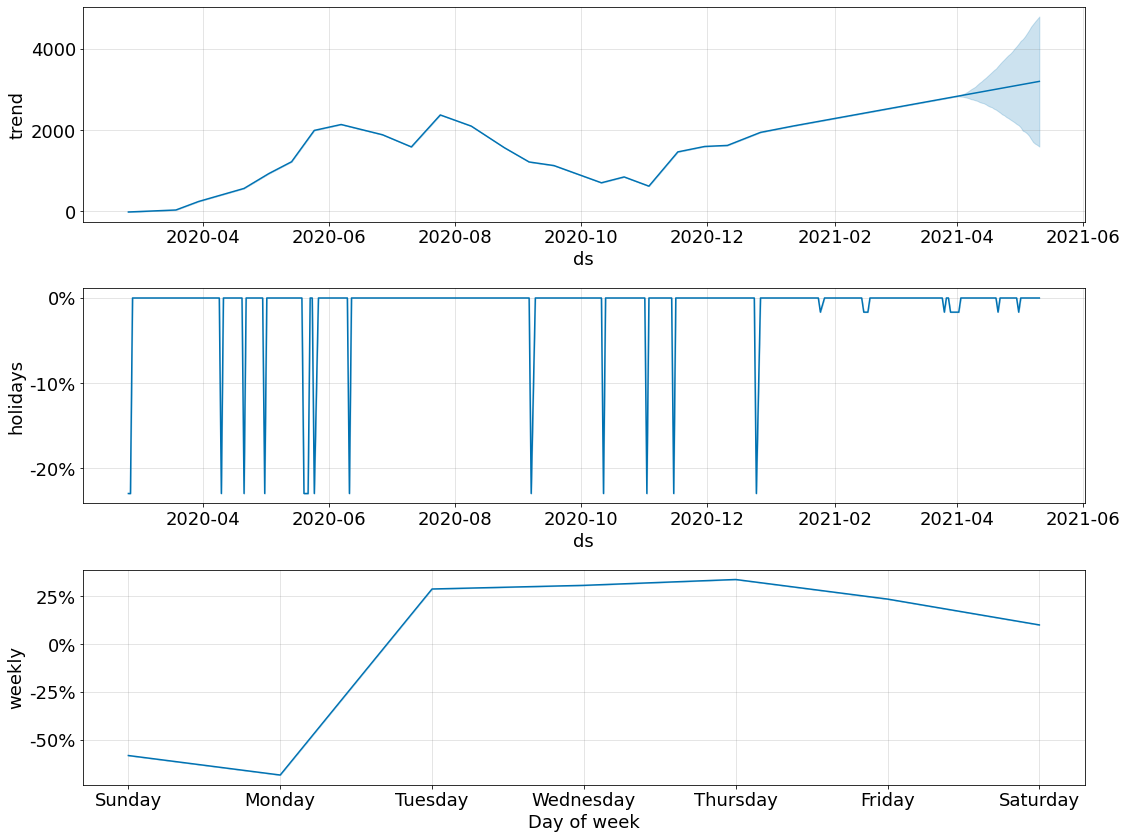

In [11]:
m2.plot_components(prev2, figsize = (16,12));

In [12]:
amostras = m2.predictive_samples(prev2)

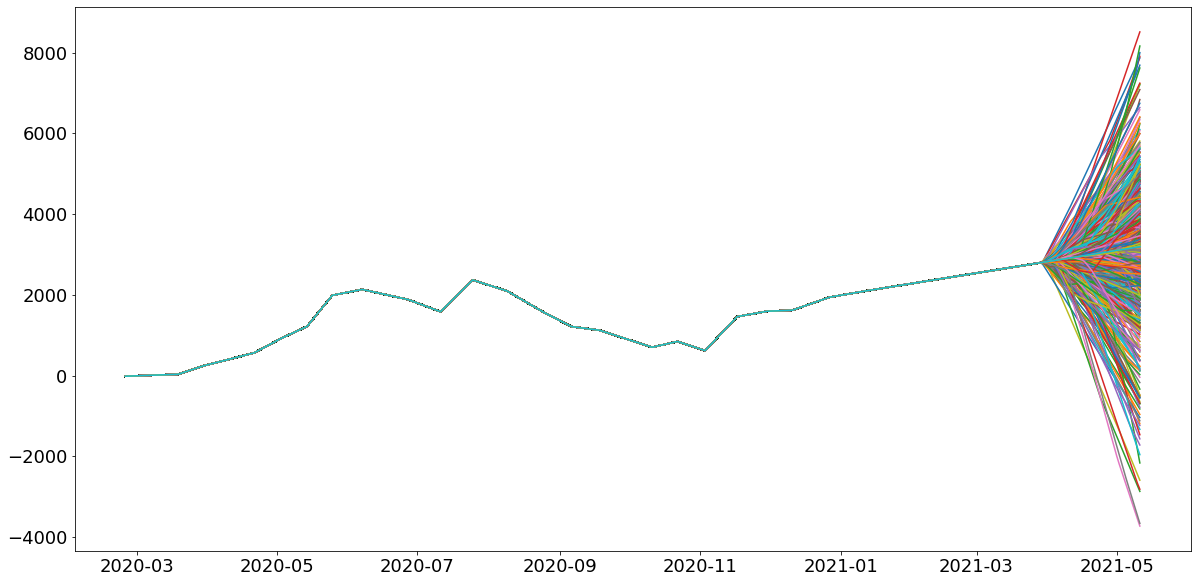

In [13]:
plt.figure(figsize = (20,10))
plt.plot(prev2.loc[:,"ds"], amostras["trend"]);

## Desafio  01 - Testar diferentes intervalos de confiança

De acordo com a [documentação](https://facebook.github.io/prophet/docs/uncertainty_intervals.html) do prophet, a incerteza da estimativa está associada com o parâmetro de escala de changepoints: se assumirmos maior taxa de variação dos possíveis changepoints nos dados de treino, aumentaremos a incerteza associada com os dados de teste.

Uma outra prática comum em análise estatística é representar o intervalo de 95% de confiança, o que também pode ser definido no nosso modelo:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


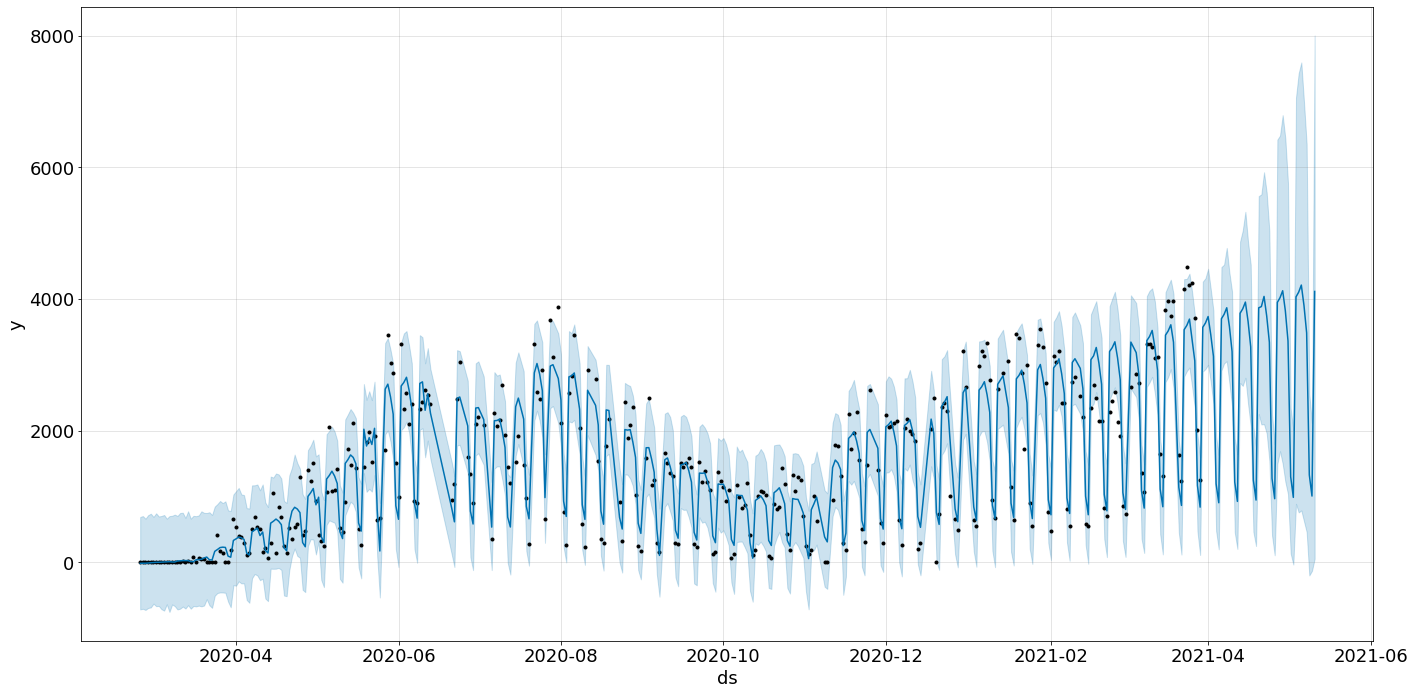

In [14]:
m3 = Prophet(changepoint_prior_scale = 10, holidays = feriados, seasonality_mode = "multiplicative", interval_width = 0.95)

m3.fit(df_no_out)

df_prev3 = m3.make_future_dataframe(periods = 43)

prev3 = m3.predict(df_prev3)

m3.plot(prev3, figsize = (20,10));

Durante o desenvolvimento do nosso modelo, vimos que o aumento do parametro change_prior_scale resultou em um melhor ajuste, mas, se aumentarmos mais ainda esse parâmetro, vemos o efeito na incerteza da previsão:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


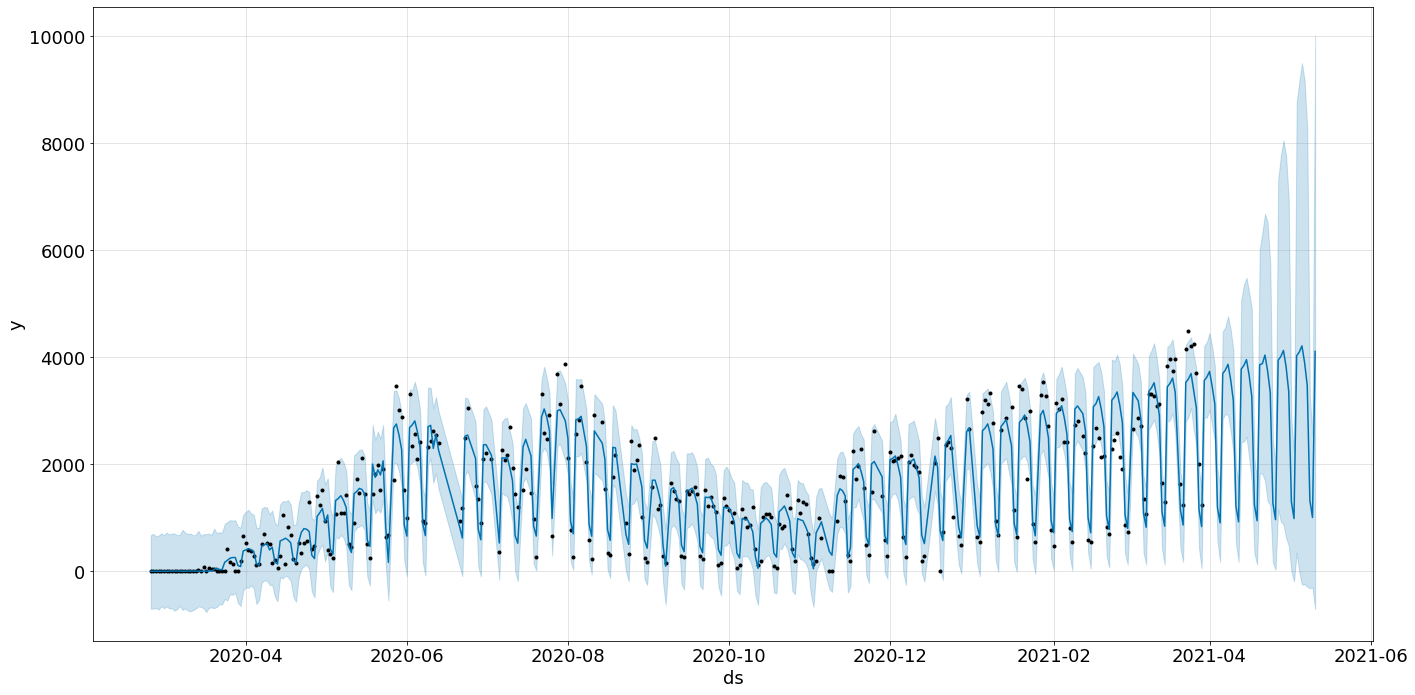

In [15]:
m4 = Prophet(changepoint_prior_scale = 100, holidays = feriados, seasonality_mode = "multiplicative", interval_width = 0.95)

m4.fit(df_no_out)

df_prev4 = m4.make_future_dataframe(periods = 43)

prev4 = m4.predict(df_prev4)

m4.plot(prev4, figsize = (20,10));

Quanto a definição da amplitude do intervalo de confiança, não vemos diferença no cálculo das estimativas **da média** do modelo, mas sim, nos intervalos, como esperado. 

## Desafio 02 - Plotar os pontos dos dados como feito originalmente, com a linha da previsão

In [16]:
df2_teste = pd.DataFrame()
df2_teste.loc[:,"ds"] = df_sp.loc[:,"datahora"][400:]
df2_teste.loc[:,"y"] = df_sp.loc[:,"casos_novos"][400:]

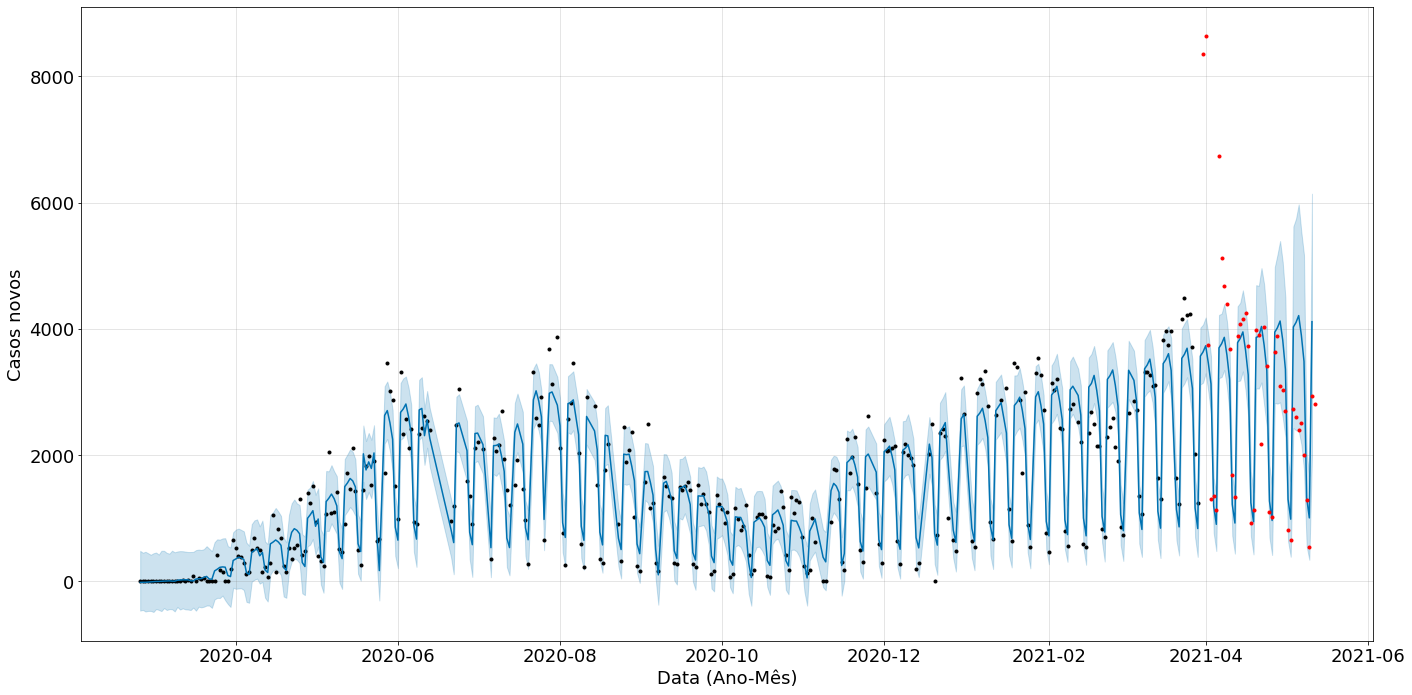

In [17]:
m2.plot(prev2, xlabel = "Data (Ano-Mês)", ylabel = "Casos novos", figsize = (20,10));
plt.plot(df2_teste.loc[:,"ds"], df2_teste.loc[:,"y"], "r.")
plt.show()

# Sessão 2 - Validação cruzada e métricas de avaliação

In [18]:
from fbprophet.diagnostics import cross_validation

In [19]:
df_cv = cross_validation(m2, initial = "180 days", period = "30 days", horizon = "30 days")

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00


In [20]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-02,1818.282176,1411.470569,2220.009957,1579,2020-08-31
1,2020-09-03,1874.059054,1436.158095,2291.969584,2496,2020-08-31
2,2020-09-04,1862.202926,1435.364884,2272.781068,1166,2020-08-31
3,2020-09-05,1431.091473,994.207887,1904.474983,1245,2020-08-31
4,2020-09-06,600.583336,162.367186,1020.047710,290,2020-08-31


In [21]:
window = 5

cutoff = df_cv.loc[:,"cutoff"].unique()[window]

In [22]:
df_cv_cut = df_cv[df_cv.loc[:,"cutoff"].values == cutoff]

Text(0.5, 0, 'ds')

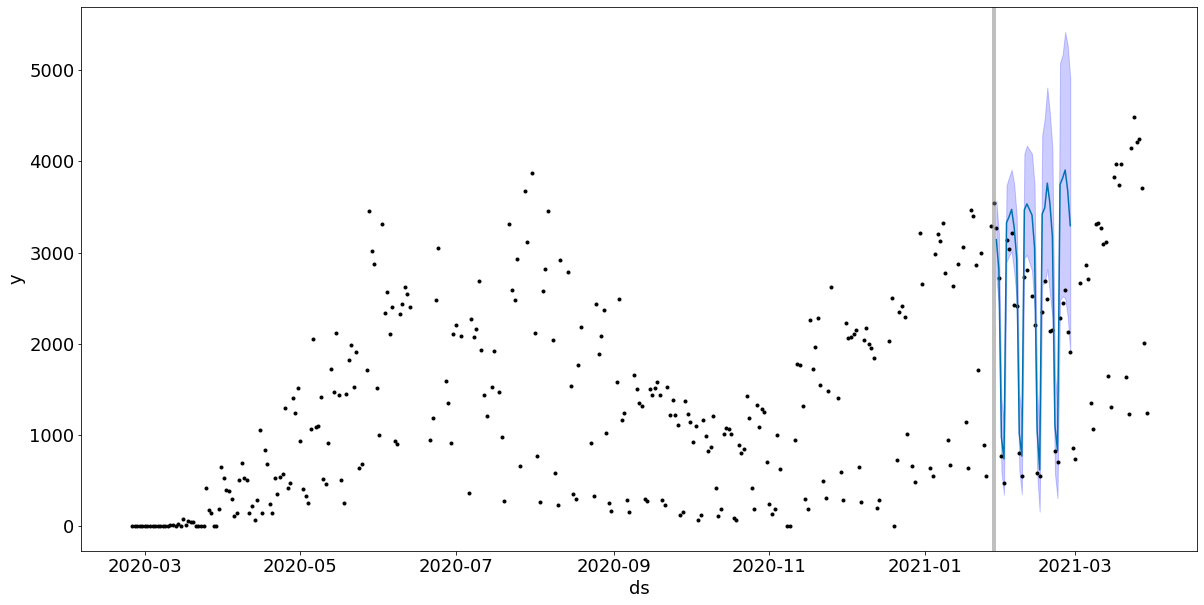

In [23]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
ax.plot(m2.history["ds"].values, m2.history["y"], "k.")
ax.plot(df_cv_cut["ds"].values, df_cv_cut["yhat"], ls = "-", c = "#0072B2")
ax.fill_between(df_cv_cut["ds"].values, df_cv_cut["yhat_lower"],
                df_cv_cut["yhat_upper"], color = "blue",
                alpha = 0.2)
ax.axvline(x = pd.to_datetime(cutoff), c = "gray", lw = 4, alpha = 0.5)
ax.set_ylabel("y")
ax.set_xlabel("ds")

In [24]:
from fbprophet.diagnostics import performance_metrics

In [25]:
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [26]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,3 days,7.128180e+04,266.986514,191.657734,0.152390,0.888889
1,4 days,1.091438e+05,330.369213,250.579050,0.199879,0.833333
2,5 days,1.043003e+05,322.955543,243.518526,0.194409,0.833333
3,6 days,9.868495e+04,314.141600,249.938112,0.184773,0.851852
4,7 days,5.787835e+04,240.579198,201.831778,0.106117,0.944444
5,8 days,1.299567e+05,360.495040,295.801132,0.144211,0.777778
6,9 days,1.296212e+05,360.029470,286.237970,0.152227,0.722222
7,10 days,1.467571e+05,383.088879,320.102600,0.198170,0.700000
8,11 days,1.060194e+05,325.606241,283.030633,0.172062,0.865079
9,12 days,1.075005e+05,327.872636,272.839314,0.148163,0.904762


In [27]:
from fbprophet.plot import plot_cross_validation_metric

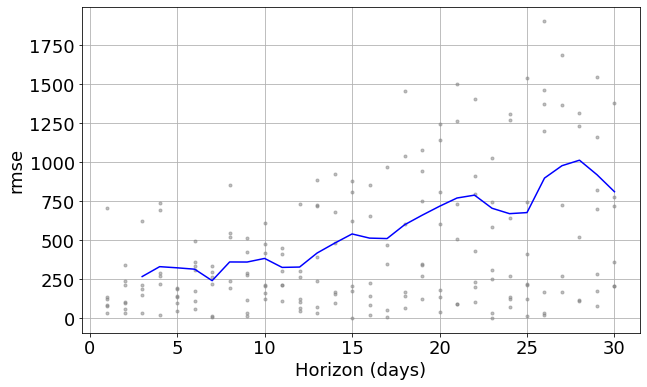

In [28]:
plot_cross_validation_metric(df_cv, metric = "rmse");

## Desafio 03 - Buscar quais métricas se aplicam a quais casos

Na documentação do Prophet sobre [cross-validation](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation), nos são apresentados as estatísticas básicas que a biblioteca utiliza para testar a perfomance do modelo, e como realizar a análise através de cross-validation. O método de cross-validation realizado no prophet por padrão é conhecido como **k-fold cross-validation**, que é mais indicado para modelos que lidam com [séries temporais](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data), pois incorporam a auto-correlação dos dados. As métricas de performance que o prophet aplica como padrão, são relativas à distância de cada dado real ao dado simulado, assim como estimativas de erro em modelos de regressão linear.

In [53]:
mpl.rcParams['figure.figsize'] = (20,8)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00


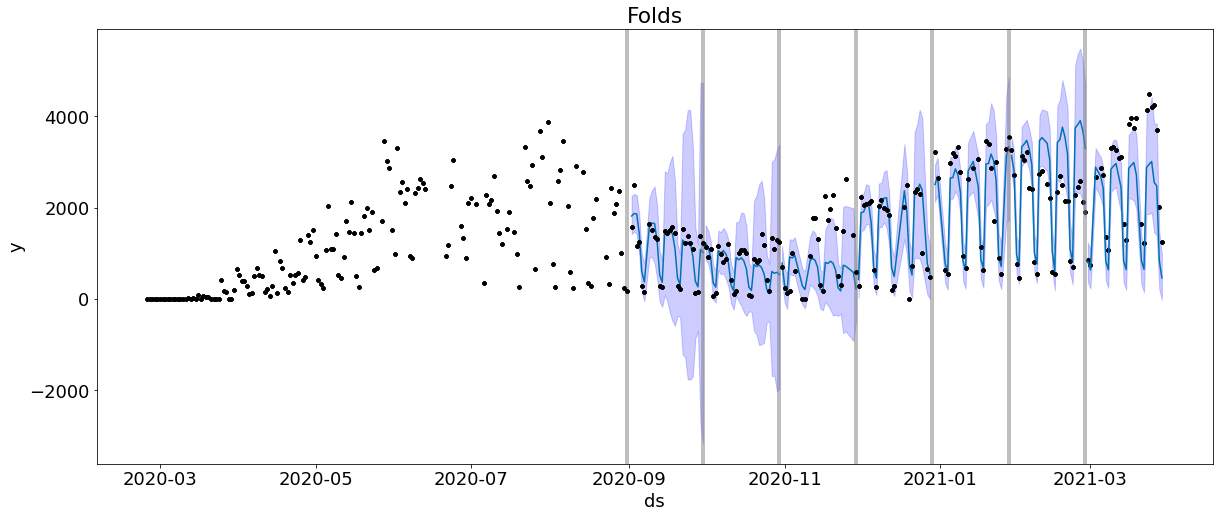

In [54]:
### código disponível em https://colab.research.google.com/drive/1zE2QSZ4TElXdk_3H-PmAjg-KG_F47ZjL?usp=sharing#scrollTo=mXnWZuWLmgiA

df_cv = cross_validation(m2, initial = "180 days", period = "30 days", horizon = "30 days")

lista_cutoff = df_cv['cutoff'].unique()


for cutoff in lista_cutoff:

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
    ax = plt.plot(m2.history['ds'].values, m2.history['y'], 'k.')

    plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')

    plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    plt.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
plt.title(f'Folds')
plt.ylabel('y')
plt.xlabel('ds')
fig.tight_layout()
plt.show()

Podemos ver que a incerteza do modelo é maior nos períodos iniciais do nosso gráfico acima, 180 dias após o início da série temporal. No nosso caso, de Setembro a Outubro de 2020, a curva de aumento de casos de COVID apresentou mudanças, começando uma dinâmica de queda que não havia em dados anteriores, e isso pode ter gerado uma incerteza maior do modelo nesse período. Após essa primeira janela, a incerteza é um pouco menor, pois a tendência de queda se confirmou e o modelo pode ter detectado melhor e agora conseguiu ajustá-la. Nos primeiros meses de 2021, a nova tendência de aumento foi tão rápida que prontamente foi detectada pelo modelo, que começa a prever aumento com uma incerteza pequena. 

Também podemos confirmar o gráfico anterior, que descreve que a acurácia do modelo medida através da métrica de RMSE diminui conforme o tempo passa, dentro de cada horizonte.

As medidas implementadas de erro médio, erro médio quadrático etc, são consideradas relativamente simples (https://aditi-mittal.medium.com/cross-validation-and-performance-measures-in-machine-learning-9dabdbed5459), mas o cálculo rápido pode ser uma vantagem para análises iniciais de performance. O tipo de métrica de performance a ser analisado também depende do [tipo de dado](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Measures_of_fit), se é binário ou contínuo, por exemplo. Outras métricas também podem ser aplicadas para se testar a performance da cross-validation, como acurácia, precisão, métricas derivadas do conceito de [matriz de confusão](https://towardsdatascience.com/cross-validation-430d9a5fee22).

Para uma discussão sobre métricas de performance: https://www.researchgate.net/publication/275280114_Performance_Evaluation_of_Machine_Learning_Algorithms_in_Post-operative_Life_Expectancy_in_the_Lung_Cancer_Patients .